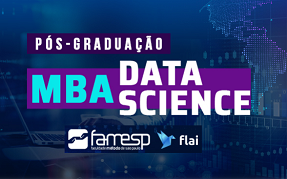



# Projeto da Disciplina de Big Data
Equipe do Projeto:
Lidiane RL Baumgratz





Documentação do Projeto - Supermercado

O projeto tem como objetivo otimizar o desempenho das vendas e operações do supermercado por meio da análise de dados relacionados ao comportamento do consumidor. A análise inclui a identificação de produtos mais vendidos, padrões de compra, horários de pico, entre outros fatores.

Objetivos do Projeto
Os principais objetivos deste projeto de análise de dados incluem:
Identificar os produtos mais vendidos no supermercado.
Analisar os padrões de compra dos clientes, incluindo a distribuição de pedidos por dia da semana e por hora do dia.
Avaliar a recorrência dos clientes, ou seja, se os clientes voltam a fazer compras.
Determinar o tempo médio entre os pedidos dos clientes.
Identificar departamentos específicos que contribuem significativamente para as vendas.
Encontrar os produtos mais populares entre os clientes.
Conjunto de Dados
Os dados utilizados neste projeto foram obtidos a partir do arquivo "ECommerce_consumer behaviour.csv", que se encontra em: https://www.kaggle.com/datasets/hunter0007/ecommerce-dataset-for-predictive-marketing-2023/code que contém informações sobre pedidos, produtos e clientes no supermercado.

O projeto faz uso das seguintes técnicas e métodos:

Análise exploratória de dados (EDA) para explorar as características do conjunto de dados.
Visualização de dados para representar graficamente os resultados da análise.
Estatísticas descritivas para resumir informações relevantes.
Testes de hipóteses para validar hipóteses específicas.
Modelagem de Machine Learning, incluindo Random Forest e ALS (Alternating Least Squares) para criação de modelos preditivos e sistemas de recomendação.

O processo de análise segue as seguintes etapas:

Preparação do Ambiente de Análise:
Instalação e configuração do ambiente de análise, incluindo a instalação do Apache Spark e outras dependências.

Carregamento e Limpeza de Dados:
Os dados são carregados a partir do arquivo CSV.
Valores nulos são removidos.
Tratamento de colunas, como a conversão da coluna "reordered" em valores binários.

Análise de Dados:
Análise de padrões de compra, distribuição de pedidos e cálculo de métricas relevantes.
Realização de testes de hipóteses para validar suposições.
Modelagem preditiva e criação de sistemas de recomendação.
Visualização de Resultados:

Apresentação de resultados por meio de gráficos, como a distribuição de pedidos por dia da semana.
Uso de gráficos de dispersão para visualizar correlações.

Interpretação de Resultados:
Identificação dos produtos mais vendidos e dos departamentos mais lucrativos.
Confirmação de que existe uma correlação entre a hora do dia e o número de pedidos.
Validação de que o dia da semana afeta o número de pedidos, com Domingo sendo estatisticamente significativo.
Estimativa do tempo médio entre os pedidos dos clientes.

Conclusão
As análises realizadas neste projeto forneceram informações valiosas sobre o comportamento dos clientes em relação às compras no supermercado. Isso pode ajudar na tomada de decisões relacionadas à programação de funcionários, gerenciamento de estoque e estratégias de retenção de clientes.

Recomendações
Concentrar recursos em Domingo e Segunda-feira, os dias de maior adesão.
Reforçar a equipe e estoque durante as horas de pico das 9h às 16h.
Monitorar de perto a recorrência dos clientes e oferecer incentivos para compras repetidas.
Manter estoque dos produtos mais vendidos em alta quantidade.

In [1]:
# instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
# configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [3]:
# tornar o pyspark "importável"
import findspark
findspark.init('spark-3.5.0-bin-hadoop3')

In [4]:
# Importar as bibliotecas necessárias
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Inicializar a sessão Spark
spark = SparkSession.builder.appName("SupermarketAnalysis").getOrCreate()

# Carregar o conjunto de dados em um DataFrame
df = spark.read.csv("ECommerce_consumer behaviour.csv", header=True)

# Tratar valores nulos
df = df.dropna()

df.show()

+--------+-------+------------+---------+-----------------+----------------------+----------+-----------------+---------+-------------+----------+----------------+
|order_id|user_id|order_number|order_dow|order_hour_of_day|days_since_prior_order|product_id|add_to_cart_order|reordered|department_id|department|    product_name|
+--------+-------+------------+---------+-----------------+----------------------+----------+-----------------+---------+-------------+----------+----------------+
| 1201011| 147243|          14|        0|               16|                   3.0|        94|                1|        0|            7| beverages|             tea|
| 1201011| 147243|          14|        0|               16|                   3.0|        83|                2|        0|            4|   produce|fresh vegetables|
| 1201011| 147243|          14|        0|               16|                   3.0|        83|                3|        1|            4|   produce|fresh vegetables|
| 1201011| 14724

In [5]:
# Criar um DataFrame de mapeamento de dia da semana.
day_of_week_mapping = spark.createDataFrame([
    (0, "Domingo"),
    (1, "Segunda-feira"),
    (2, "Terça-feira"),
    (3, "Quarta-feira"),
    (4, "Quinta-feira"),
    (5, "Sexta-feira"),
    (6, "Sábado")
], ["order_dow", "day_of_week_name"])

# Realizar uma junção com base na coluna "order_dow".
result_df = df.join(day_of_week_mapping, "order_dow", "left")

# O DataFrame "result_df" conterá a coluna "day_of_week_name" com os nomes dos dias da semana.
result_df.show()


+---------+--------+-------+------------+-----------------+----------------------+----------+-----------------+---------+-------------+----------+----------------+----------------+
|order_dow|order_id|user_id|order_number|order_hour_of_day|days_since_prior_order|product_id|add_to_cart_order|reordered|department_id|department|    product_name|day_of_week_name|
+---------+--------+-------+------------+-----------------+----------------------+----------+-----------------+---------+-------------+----------+----------------+----------------+
|        0| 1201011| 147243|          14|               16|                   3.0|        94|                1|        0|            7| beverages|             tea|         Domingo|
|        0| 1201011| 147243|          14|               16|                   3.0|        83|                2|        0|            4|   produce|fresh vegetables|         Domingo|
|        0| 1201011| 147243|          14|               16|                   3.0|        83|  

 **2. Hipóteses**

Podemos identificar algumas hipóteses a serem validadas durante a análise

Hipótese 1: Existe um dia da semana com mais pedidos do que outros?
Hipótese 2: Existe uma correlação entre a hora do dia e o número de pedidos?
Hipótese 3: Há alguns produtos recorrentes no carrinho?
Hipótese 4: QUal o tempo médio entre pedidos?
Hipótese 5: Departamentos específicos têm vendas mais altas do que outros?
Hipótese 6: Quais os produtos mais populares?

In [6]:
data = spark.read.csv("ECommerce_consumer behaviour.csv", header=True, inferSchema=True)

# Hipótese 1 - Distribuição de pedidos por dia da semana - A Distribuição de Pedidos por Dia da Semana pode ajudar a identificar os dias mais movimentados da semana (Domingo e segunda) para planejar a programação de funcionários e gerenciar estoque de maneira eficaz.
orders_by_day_of_week = data.groupBy("order_dow").agg(count("*").alias("order_count"))
result_df = orders_by_day_of_week.join(day_of_week_mapping, "order_dow", "inner")
result_df = result_df.select("day_of_week_name", "order_count")
result_df = result_df.orderBy(F.desc("order_count"))

# Comparar a média de pedidos em Domingo (order_dow=0) com a média geral
sunday_mean = orders_by_day_of_week.filter(col("order_dow") == 0).select("order_count").collect()[0]["order_count"]
overall_mean = orders_by_day_of_week.agg(avg("order_count")).collect()[0]["avg(order_count)"]

# Realizar um teste de hipótese para verificar se a diferença é significativa
from scipy import stats

alpha = 0.05  # Nível de significância
t_stat, p_value = stats.ttest_1samp([sunday_mean], overall_mean)

if p_value < alpha:
    print("A diferença é estatisticamente significativa. Domingo tem mais pedidos.")
else:
    print("Não há diferença estatisticamente significativa entre os dias da semana.")

# Hipótese 2 - Distribuição de pedidos por hora do dia - Ajuda a determinar os horários de pico de compras (das 9h as 16h) e otimizar o dimensionamento de funcionários para atender a demanda.
orders_by_hour_of_day = data.groupBy("order_hour_of_day").agg(count("*").alias("order_count"))
orders_by_hour_of_day = orders_by_hour_of_day.orderBy(F.desc("order_count"))
# Coletar os dados em um DataFrame Pandas
orders_data = orders_by_hour_of_day.toPandas()

# Calcular o coeficiente de correlação entre a hora do dia e o número de pedidos
correlation = orders_data["order_hour_of_day"].corr(orders_data["order_count"], method="pearson")

if correlation > 0:
    print("Existe uma correlação positiva entre a hora do dia e o número de pedidos.")
elif correlation < 0:
    print("Existe uma correlação negativa entre a hora do dia e o número de pedidos.")
else:
    print("Não há correlação linear significativa entre a hora do dia e o número de pedidos.")

# Calcular o p-valor para determinar a significância estatística da correlação.
from scipy.stats import pearsonr

correlation, p_value = pearsonr(orders_data["order_hour_of_day"], orders_data["order_count"])
alpha = 0.05  # Nível de significância

if p_value < alpha:
    print(f"A correlação é estatisticamente significativa (p-valor = {p_value:.4f}).")
else:
    print(f"A correlação não é estatisticamente significativa (p-valor = {p_value:.4f}).")

# Hipótese 3 - Frequência de produtos adicionados ao carrinho - Produtos frequentemente reordenados podem indicar lealdade do cliente a certos itens, o que é valioso para a gestão de estoque.
products_added_to_cart = data.groupBy("product_id").agg(avg("add_to_cart_order").alias("avg_add_to_cart_order"))
products_added_to_cart = products_added_to_cart.orderBy(F.desc("avg_add_to_cart_order"))

products_reordered = data.groupBy("product_id").agg(avg("reordered").alias("avg_reorder_rate"))
products_reordered = products_reordered.orderBy(F.desc("avg_reorder_rate"))

# Hipótese 4 - Tempo médio entre os pedidos - O tempo Médio Entre Pedidos de 11.39 dias ( aprox. 3x por mes) pode ajudar a entender o comportamento de repetição de compra dos clientes e planejar estratégias de retenção de clientes.
avg_time_between_orders = df.select(avg("days_since_prior_order").alias("avg_time_between_orders")).collect()[0]["avg_time_between_orders"]
print(f"O tempo médio entre pedidos é de {avg_time_between_orders:.2f} dias.")

# Hipótese 5 - Departamento mais lucrativo - Identificar o departamento que contribui mais para as vendas ajuda na alocação de recursos e decisões de merchandising.
most_profitable_department = data.groupBy("department").agg(count("*").alias("department_sales")).orderBy(col("department_sales").desc())

# Hipótese 6 - Produtos mais populares - Produtos que chamam a atenção dos clientes e geram mais conexão com os outros produtos.
most_popular_products = data.groupBy("product_name").agg(count("*").alias("product_count")).orderBy(col("product_count").desc())

# Visualização dos resultados
result_df.show()
orders_by_hour_of_day.show()
products_added_to_cart.show()
products_reordered.show()
most_profitable_department.show()
most_popular_products.show()


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Não há diferença estatisticamente significativa entre os dias da semana.
Existe uma correlação positiva entre a hora do dia e o número de pedidos.
A correlação não é estatisticamente significativa (p-valor = 0.0921).
O tempo médio entre pedidos é de 11.40 dias.
+----------------+-----------+
|day_of_week_name|order_count|
+----------------+-----------+
|         Domingo|      92740|
|   Segunda-feira|      80688|
|          Sábado|      65251|
|     Sexta-feira|      61562|
|     Terça-feira|      60903|
|    Quarta-feira|      54881|
|    Quinta-feira|      54464|
+----------------+-----------+

+-----------------+-----------+
|order_hour_of_day|order_count|
+-----------------+-----------+
|               10|      40192|
|               11|      40006|
|               14|      39131|
|               15|      39043|
|               13|      39014|
|               12|      37960|
|               16|      37596|
|                9|      35181|
|               17|      29765|
|           

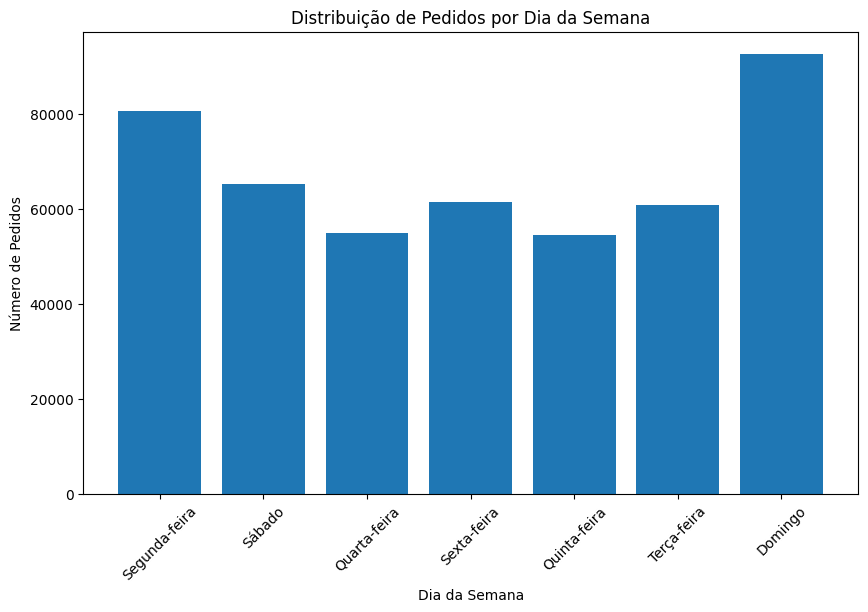

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Coletar os dados em um DataFrame Pandas
orders_data = orders_by_day_of_week.toPandas()

# Mapear os nomes dos dias da semana
day_names = ["Domingo", "Segunda-feira", "Terça-feira", "Quarta-feira", "Quinta-feira", "Sexta-feira", "Sábado"]
orders_data["day_of_week_name"] = orders_data["order_dow"].apply(lambda x: day_names[x])

# Criar um gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(orders_data["day_of_week_name"], orders_data["order_count"])
plt.xlabel("Dia da Semana")
plt.ylabel("Número de Pedidos")
plt.title("Distribuição de Pedidos por Dia da Semana")
plt.xticks(rotation=45)
plt.show()

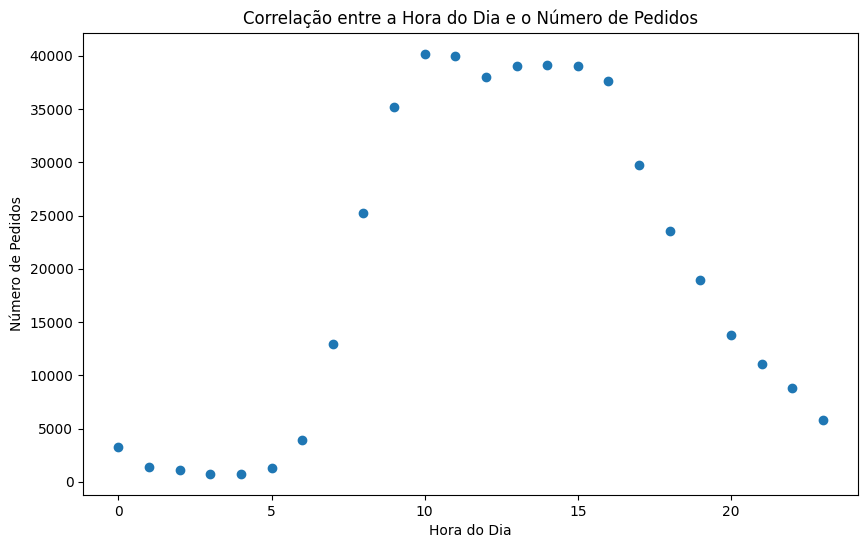

In [19]:
# Coletar os dados em um DataFrame Pandas
orders_data = orders_by_hour_of_day.toPandas()

# Criar um gráfico de dispersão para visualizar a correlação
plt.figure(figsize=(10, 6))
plt.scatter(orders_data["order_hour_of_day"], orders_data["order_count"])
plt.xlabel("Hora do Dia")
plt.ylabel("Número de Pedidos")
plt.title("Correlação entre a Hora do Dia e o Número de Pedidos")
plt.show()


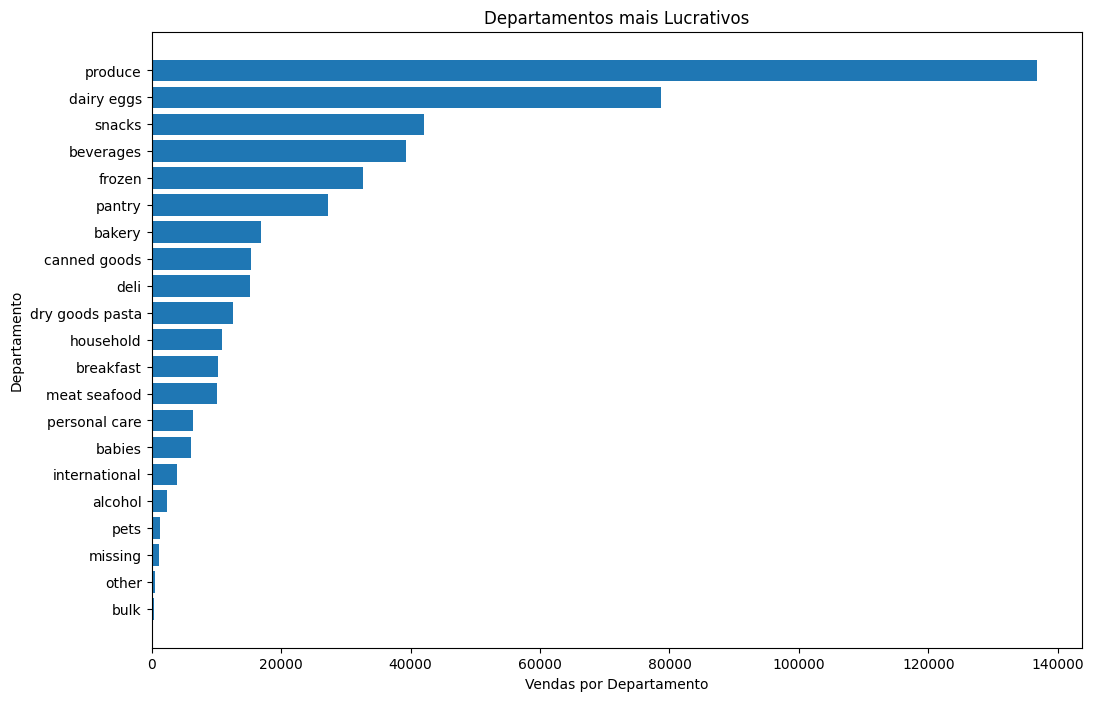

In [20]:
# Coletar os dados em um DataFrame Pandas
most_profitable_department_data = most_profitable_department.toPandas()

# Criar um gráfico de barras para visualizar os departamentos mais lucrativos
plt.figure(figsize=(12, 8))
plt.barh(most_profitable_department_data["department"], most_profitable_department_data["department_sales"])
plt.xlabel("Vendas por Departamento")
plt.ylabel("Departamento")
plt.title("Departamentos mais Lucrativos")
plt.gca().invert_yaxis()  # Inverter a ordem dos departamentos
plt.show()


In [8]:
from pyspark.ml import Pipeline

# Converter a coluna "reordered" em um valor numérico (0 ou 1)
df = df.withColumn("reordered", when(df["reordered"] == "Yes", 1).otherwise(0))

# Selecionar as colunas relevantes para o modelo
feature_cols = ["order_dow", "order_hour_of_day", "days_since_prior_order", "reordered"]
df = df.select(feature_cols)

# Criar um VectorAssembler para combinar as features em uma única coluna
vector_assembler = VectorAssembler(inputCols=feature_cols[:-1], outputCol="features")

# Criar o modelo RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="reordered")

# Criar um pipeline para encadear as etapas
pipeline = Pipeline(stages=[vector_assembler, rf])

# Dividir os dados em conjuntos de treinamento e teste
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


In [9]:
# Para a coluna "order_dow"
order_dow_indexer = StringIndexer(inputCol="order_dow", outputCol="order_dow_index")

# Para a coluna "order_hour_of_day"
order_hour_indexer = StringIndexer(inputCol="order_hour_of_day", outputCol="order_hour_of_day_index")


In [10]:
# Aplicar os indexadores ao DataFrame
df = order_dow_indexer.fit(df).transform(df)
df = order_hour_indexer.fit(df).transform(df)


In [11]:
# Verificar o esquema e os nomes das colunas em train_data
print("Esquema de train_data:")
train_data.printSchema()
print("Nomes das colunas em train_data:", train_data.columns)

# Verificar o esquema e os nomes das colunas em test_data
print("Esquema de test_data:")
test_data.printSchema()
print("Nomes das colunas em test_data:", test_data.columns)

# Comparar com as colunas especificadas nas etapas do pipeline
print("Colunas especificadas nas etapas do pipeline:", feature_cols)  # Substitua feature_cols pelos nomes corretos das colunas no seu caso



Esquema de train_data:
root
 |-- order_dow: string (nullable = true)
 |-- order_hour_of_day: string (nullable = true)
 |-- days_since_prior_order: string (nullable = true)
 |-- reordered: integer (nullable = false)

Nomes das colunas em train_data: ['order_dow', 'order_hour_of_day', 'days_since_prior_order', 'reordered']
Esquema de test_data:
root
 |-- order_dow: string (nullable = true)
 |-- order_hour_of_day: string (nullable = true)
 |-- days_since_prior_order: string (nullable = true)
 |-- reordered: integer (nullable = false)

Nomes das colunas em test_data: ['order_dow', 'order_hour_of_day', 'days_since_prior_order', 'reordered']
Colunas especificadas nas etapas do pipeline: ['order_dow', 'order_hour_of_day', 'days_since_prior_order', 'reordered']


In [12]:
df = df.withColumnRenamed("days_since_prior_order_index", "days_since_prior_order_index_temp")


In [13]:
df = df.withColumnRenamed("userId", "user").withColumnRenamed("productId", "item")



In [14]:
(training_data, test_data) = data.randomSplit([0.8, 0.2])



In [15]:
from pyspark.ml.recommendation import ALS

# Criar o modelo ALS
als = ALS(maxIter=5, regParam=0.01, userCol="user_id", itemCol="product_id", ratingCol="reordered", implicitPrefs=True)

# Treinar o modelo
model = als.fit(training_data)


In [16]:
# fazer recomendações para todos os usuários
all_user_recommendations = model.recommendForAllUsers(numItems=10)
all_user_recommendations.show()


+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|      3|[{100, 0.0}, {99,...|
|     17|[{24, 0.860124}, ...|
|     34|[{100, 0.0}, {99,...|
|     35|[{24, 1.2165695},...|
|     37|[{24, 1.2477833},...|
|     52|[{107, 0.5509132}...|
|     57|[{100, 0.0}, {99,...|
|     81|[{32, 0.5569}, {7...|
|     86|[{24, 0.9457256},...|
|     96|[{120, 0.8761479}...|
|    117|[{107, 0.610806},...|
|    122|[{21, 0.53829587}...|
|    126|[{83, 0.9230189},...|
|    140|[{83, 1.4469318},...|
|    142|[{24, 0.95806736}...|
|    169|[{100, 0.0}, {99,...|
|    190|[{100, 0.0}, {99,...|
|    210|[{83, 1.5549605},...|
|    222|[{3, 0.41916686},...|
|    227|[{24, 1.1932907},...|
+-------+--------------------+
only showing top 20 rows



In [17]:
item_recs = model.recommendForAllItems(3)
item_recs.show()

+----------+--------------------+
|product_id|     recommendations|
+----------+--------------------+
|         1|[{95967, 0.190200...|
|         2|[{175540, 0.17658...|
|         3|[{179364, 1.81066...|
|         4|[{175540, 0.54806...|
|         5|[{180492, 0.07768...|
|         6|[{95967, 0.051121...|
|         7|[{88149, 0.058038...|
|         8|[{95967, 0.071309...|
|         9|[{175540, 0.49634...|
|        10|[{33142, 0.006772...|
|        11|[{95967, 0.036377...|
|        12|[{175540, 0.10621...|
|        13|[{175540, 0.25278...|
|        14|[{87247, 0.368512...|
|        15|[{175540, 0.05370...|
|        16|[{28453, 0.698568...|
|        17|[{88149, 0.363763...|
|        18|[{179364, 0.04191...|
|        19|[{147855, 0.27729...|
|        20|[{95967, 0.105489...|
+----------+--------------------+
only showing top 20 rows

